In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from pecan.vineyards_oineus import compute_vineyards
import seaborn as sns
import matplotlib.pyplot as plt

# Computing Vineyards on point clouds and graphs

## Using a point cloud

### Data Generation

In [2]:
#distance matrix at time 0
points = np.random.randn(50,3)
dist = squareform(pdist(points))

#distance matrix at time 1
points1 = np.random.randn(50,3)
dist1 = squareform(pdist(points1))

In [3]:
points_list = [points,points1]

### Vineyards computation

In [4]:
filtration_args = {'max_radius': 5}

In [7]:
vineyards_dict = compute_vineyards(points_list, vr_type = "pc", filtration_args = filtration_args)

Computing T0


100%|██████████| 10/10 [00:02<00:00,  5.00it/s]


Computing T1


### Selecting which simplices to track

In [8]:
### Getting the simplices with highest persistence at time 0

t0_dict = {k:v[0] for k,v in vineyards_dict.items() if v[0][1] is not None} # Persistence diagram at t=0

persistence_t0_dim0 = { k: v[1]-v[0] for k,v in t0_dict.items() if v[-1] == 0  }
persistence_t0_dim1 = { k: v[1]-v[0] for k,v in t0_dict.items() if v[-1] == 1 }

## SHow the 10 first simplices with highest persistence
sorted_dim0 = sorted(persistence_t0_dim0.items(), key=lambda item: item[1], reverse=True)
sorted_dim1 = sorted(persistence_t0_dim1.items(), key=lambda item: item[1], reverse=True)
best_names_dim0 = [x[0] for x in sorted_dim0[:10]]
best_names_dim1 = [x[0] for x in sorted_dim1[:10]]

print("Highest persistence simplices for dim 0")
print(best_names_dim0)
print("Highest persistence simplices for dim 1")
print(best_names_dim1)

Highest persistence simplices for dim 0
['7-42', '1-36', '11-13', '6-46', '15-18', '21-27', '6-9', '6-20', '19-48', '28-45']
Highest persistence simplices for dim 1
['0-32-45', '0-29-49', '0-4-28', '0-32-49', '0-27-40', '0-2-28', '0-9-17', '0-2-17', '0-28-49', '0-4-17']


### Printing

In [14]:
color_dict = sns.color_palette("Set2", 10)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_vineyards(simplex_id, base_dict, color_dict, max_value = 5, dim_p = 0):
    ### Max value if the value plotted if the persistence is infinite

    if not isinstance(simplex_id,list):
        simplex_id = [simplex_id]

    fig,ax = plt.subplots()
    
    for i_s, s_id in enumerate(simplex_id):
        
        if type(s_id) == int:
            simplex_name = list(base_dict.keys())[s_id]
        else:
            simplex_name = s_id
        simplex = base_dict[simplex_name]
        x = []
        y = []
        dim = []
        t = []
        p = []
        c = []
        
        for step in range(len(simplex)):

            if simplex[step][1] is None:
                continue
            dim_ = simplex[step][3]
            if dim_ != dim_p:
                continue
            t.append(simplex[step][0])
            x.append(simplex[step][1])
            y.append(simplex[step][2])
            p.append(y[-1] - x[-1])
            if np.isinf(p[-1]):
                p[-1] = max_value
            c.append(len(simplex_name.split('-')))
            dim.append(simplex[step][3])
            ax.scatter(t[-1], p[-1], c= color_dict[i_s])
        ax.plot(t,p, c = color_dict[i_s])
    ax.set_xlabel("Time")
    ax.set_ylabel("Persistence")

#### Dim 0 

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_28564/3785308748.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[-1], p[-1], c= color_dict[i_s])


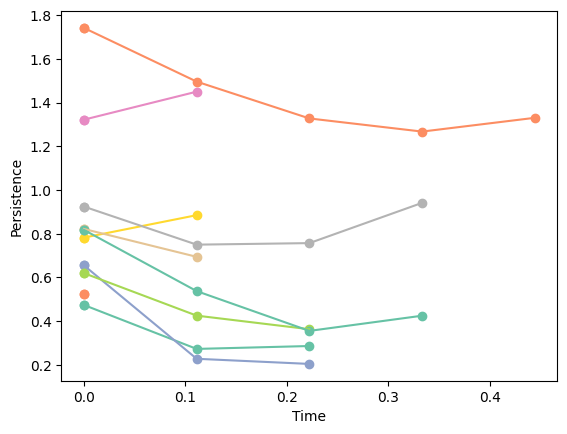

In [15]:
plot_vineyards(best_names_dim0,vineyards_dict, color_dict=color_dict, dim_p = 0)

#### Dim 1

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_28564/3785308748.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[-1], p[-1], c= color_dict[i_s])


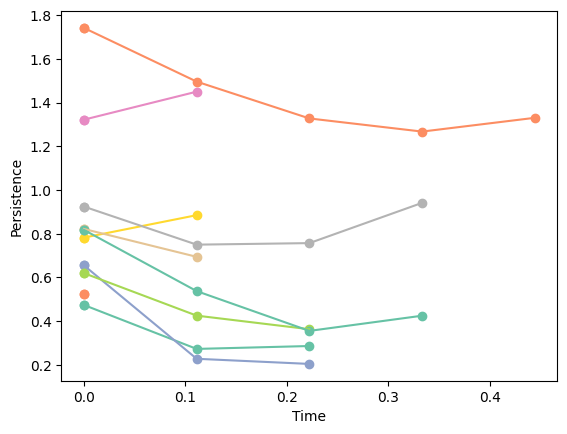

In [16]:
plot_vineyards(best_names_dim0,vineyards_dict, color_dict=color_dict, dim_p = 0)

## Using an adjacency matrix

### Data Generation

In [17]:
import networkx as nx

In [18]:
graph0 = nx.graph_atlas_g()[800]
graph1 = nx.graph_atlas_g()[801]

W1 = nx.adjacency_matrix(graph0).todense()
W2 = nx.adjacency_matrix(graph1).todense()

assert len(W1) == len(W2)

n_points = len(W1)
d1 = squareform(pdist(np.random.randn(n_points,3)))
W1 = W1 * d1

d2 = squareform(pdist(np.random.randn(n_points,3)))
W2 = W2 * d2

#### Transform adjacencies into "distances"

1 becomes the furthest away distance in the graph - this is used later in the code

In [19]:
D1 = np.exp(-W1)
D1[np.diag_indices(len(D1))] = 0

D2 = np.exp(-W2)
D2[np.diag_indices(len(D2))] = 0

### Compute the vineyards using the distance matrix

In [24]:
dist_list = [D1,D2]

In [21]:
filtration_args = {'max_radius': 0.99}

In [28]:
vineyards_dict = compute_vineyards(dist_list, vr_type = "distance", filtration_args = filtration_args)

Computing T0


100%|██████████| 10/10 [00:00<00:00, 3437.67it/s]

Computing T1


### Selecting which vertices to plot

In [30]:
### Getting the simplices with highest persistence at time 0

t0_dict = {k:v[0] for k,v in vineyards_dict.items() if v[0][1] is not None} # Persistence diagram at t=0

persistence_t0_dim0 = { k: v[1]-v[0] for k,v in t0_dict.items() if v[-1] == 0  }
persistence_t0_dim1 = { k: v[1]-v[0] for k,v in t0_dict.items() if v[-1] == 1 }

## SHow the 10 first simplices with highest persistence
sorted_dim0 = sorted(persistence_t0_dim0.items(), key=lambda item: item[1], reverse=True)
sorted_dim1 = sorted(persistence_t0_dim1.items(), key=lambda item: item[1], reverse=True)
best_names_dim0 = [x[0] for x in sorted_dim0[:10]]
best_names_dim1 = [x[0] for x in sorted_dim1[:10]]

print("Highest persistence simplices for dim 0")
print(best_names_dim0)
print("Highest persistence simplices for dim 1")
print(best_names_dim1)

Highest persistence simplices for dim 0
['4-5', '1-6', '2-6', '2-3', '0-5', '4-6', '0']
Highest persistence simplices for dim 1
['1-5-6', '3-4', '0-5-6', '2-5-6', '4-5-6']


### Plotting the vineyards

#### Dim 0 

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_28564/3785308748.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[-1], p[-1], c= color_dict[i_s])


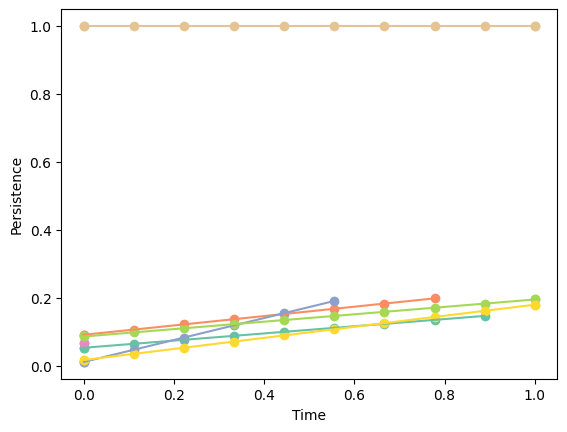

In [32]:
plot_vineyards(best_names_dim0,vineyards_dict, color_dict=color_dict, dim_p = 0, max_value = 1)

#### Dim 1

/var/folders/mt/chc1ffgd6vbcj65ckwqbppw80000gn/T/ipykernel_28564/3785308748.py:43: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[-1], p[-1], c= color_dict[i_s])


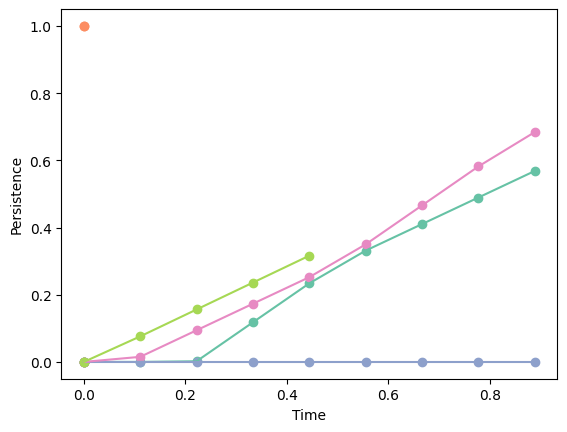

In [33]:
plot_vineyards(best_names_dim1,vineyards_dict, color_dict=color_dict, dim_p = 1, max_value = 1)